**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]
- Sean Luke, *Essentials of Metaheuristics* [2nd edition]

.

.

# LAB9
Write a local-search algorithm (eg. an EA) able to solve the Problem instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

## Black-box optimization
In this lab, we will explore the use of local-search algorithms to solve **black-box optimization problems**. In this kind of problems, the details of the fitness function remain concealed to the algorithm, which can only evaluate candidate solutions by calling the function itself.

> ❗ The algorithm must be able to probe the fitness landscape, and find a good solution, yet devoid of any information regarding the inner workings or mathematical properties of the function.



### Abstract problem definition
The provided code in [lab9_lib.py](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/Labs/Lab_09/lab9_lib.py) establishes the problem space through the `AbstractProblem` class, offering a framework for defining problem instances with varying genome length.

In [1]:
from random import choices, random
import lab9_lib as abstract_problem
import matplotlib.pyplot as plt

In [71]:
fitness = abstract_problem.make_problem(10)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

11001010011001110110111101000111101111011000110110: 9.11%
00010001101110010111111000111110010111000100010101: 9.33%
11000010000111000111000101010000100011011111010001: 29.56%
10100011001111010111110010000010110011111101111011: 9.33%
10100000101001100000001000010111110001011110011110: 15.36%
00110110110001010100110101110100011101100100100011: 15.33%
00111001101100101001010100111000110010100101101011: 23.34%
10011110011010111000010010111001101010001101100001: 9.13%
10000110001111101001111111010000001101110101010100: 7.33%
11000011000111011010000001010100000010101000110100: 17.56%
10


In [31]:
class Individual:
    
    def __init__(self, num_loci: int):
        self.num_loci = num_loci
        self.genome = choices([0, 1], k=num_loci)
        self.fitness = None

    def __str__(self):
        return f"Fitness: {self.fitness:.2%}"
    
    def __repr__(self):
        return str(self)
    
    def show(self):
        """Show the genome as a grayscale image and print the fitness."""
        plt.figure(figsize=(20, 20))
        plt.imshow([self.genome], cmap="Greys", aspect=10)
        plt.yticks([])
        plt.xticks([i*100 for i in range(self.num_loci//100+1)])
        plt.title(f"Fitness: {self.fitness:.2%}")
        plt.show()

    def compute_fitness(self, fitness_function):
        self.fitness = fitness_function(self.genome)

    
    

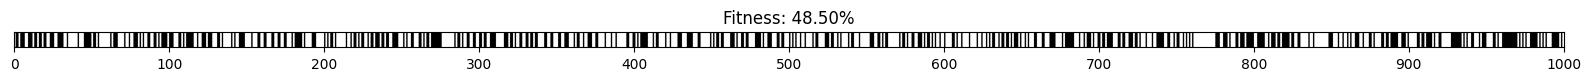

0.485


In [69]:
ind = Individual(1000, abstract_problem.make_problem(1))
ind.show()
print(ind.fitness)

In [45]:
def make_population(pop_size: int, num_loci: int, fitness_function):

    """Make a population of individuals with unique genomes."""
    population = []     # list of individuals
    hash_table = {}     # hash table to keep track of unique individuals

    while len(population) < pop_size:
        # 1. Generate a new random individual
        ind = Individual(num_loci)
        
        # 2. Only if its genome is unique
        if tuple(ind.genome) not in hash_table:
            # 2.1 Add the individual to the population
            population.append(ind)
            # 2.2 Compute the fitness of the individual
            ind.compute_fitness(fitness_function)
            # 2.3 Add the genome to the hash table
            hash_table[tuple(ind.genome)] = ind.fitness
    
    return population, hash_table


def find_best(population: list):
    """Find the individual with the highest fitness."""
    return max(population, key=lambda ind: ind.fitness)

def find_worst(population: list):
    """Find the individual with the lowest fitness."""
    return min(population, key=lambda ind: ind.fitness)

In [ ]:
def uniform_xover(parent1: Individual, parent2: Individual):
    """Perform uniform crossover on two parents."""
    

In [ ]:
def mutate_gene(ind: Individual, tested_individuals: dict, num_genes: int):

  """
    Mutate all the loci of an individual's gene to create a new individual.
    - The mutation rate is based on the fitness of the individual.
  """

  # 0. Compute the mutation rate based on the fitness of the individual
  mutation_rate = 1 - ind.fitness
 
  # 1. Select the gene to mutate
  gene = random.randint(0, num_genes-1)
  gene_len = ind.num_loci // num_genes

  # 2. For each locus in the gene
  for i in range(gene*gene_len, (gene+1)*gene_len):
    # 2.1. Mutate the locus with the given mutation rate
    if random() < mutation_rate:
      ind.genome[i] = 1 - ind.genome[i]
  
  # 3. Set the fitness of the individual
  if tuple(ind.genome) not in tested_individuals:
    ind.compute_fitness(fitness)
    tested_individuals[tuple(ind.genome)] = ind.fitness
  else:
    ind.fitness = tested_individuals[tuple(ind.genome)]

def mutate_locus(ind: Individual, tested_individuals: dict):
  """
    Mutate a single locus in a gene of an individual's genome to create a new individual.
    - The mutation rate is based on the fitness of the individual.
  """

  # 0. Compute the mutation rate based on the fitness of the individual
  mutation_rate = 1 - ind.fitness
 
  # 1. Select the locus to mutate
  locus = random.randint(0, ind.num_loci-1)

  # 2. Mutate the locus with the given mutation rate
  if random() < mutation_rate:
    ind.genome[locus] = 1 - ind.genome[locus]
  
  # 3. Set the fitness of the individual
  if tuple(ind.genome) not in tested_individuals:
    ind.compute_fitness(fitness)
    tested_individuals[tuple(ind.genome)] = ind.fitness
  else:
    ind.fitness = tested_individuals[tuple(ind.genome)]

In [43]:
PROBLEM_INSTANCES = [1, 2, 5, 10]
NUM_LOCI = 1000

POPULATION_SIZE = 100
OFFSPRING_SIZE = 50
NUM_GENERATIONS = 100


# Promoting diversity

In [68]:
PROBLEM_INSTANCE = 10
fitness_function = abstract_problem.make_problem(PROBLEM_INSTANCE)

# 0. Create the initial population
individuals, tested_individuals = make_population(POPULATION_SIZE, NUM_LOCI, fitness_function)
best_individual =  find_best(individuals)

# 1. Run the evolutionary algorithm



print(f"Generation 0: {best_individual}")
print(f"Tested individuals: {len(tested_individuals)}")
print(f"Fitness function calls: {fitness_function.calls}")

Generation 0: Fitness: 17.36%
Tested individuals: 100
Fitness function calls: 100
